![hslu_logo.png](img/hslu_logo.png)

## Week 01

<hr style="border:1px solid black">

# Excercise: Single-Layer-Perceptron using PyTorch
---
---
This excercise is to illustrate a first "real" classification problem using a single-layer-perceptron on MNIST or FashionMNIST data.

### Import necessary packages

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from utils import read_data, plot_img, plot_tiles

#### Read dataset (MNIST or FashionMNIST)

In [2]:
#data is save in storage_path (use same path for different SW)
training_data, test_data, labels_map = read_data(data_type='FashionMNIST', storage_path='./data')

#to access the images
print(f'training data shape {training_data.data.shape} and type {training_data.data.dtype} ')
print(f'test data shape {test_data.data.shape} and type {test_data.data.dtype} ')

#to access the labels
print(f'training data shape {training_data.targets.shape} and type {training_data.targets.dtype} ')
print(f'test data shape {test_data.targets.shape} and type {test_data.targets.dtype} ')
print(f'categories: {labels_map}')

training data shape torch.Size([60000, 28, 28]) and type torch.uint8 
test data shape torch.Size([10000, 28, 28]) and type torch.uint8 
training data shape torch.Size([60000]) and type torch.int64 
test data shape torch.Size([10000]) and type torch.int64 
categories: {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


#### plot sample images 

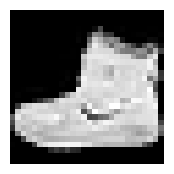

In [3]:
plot_img(training_data.data[0], figure_size = [2,2])

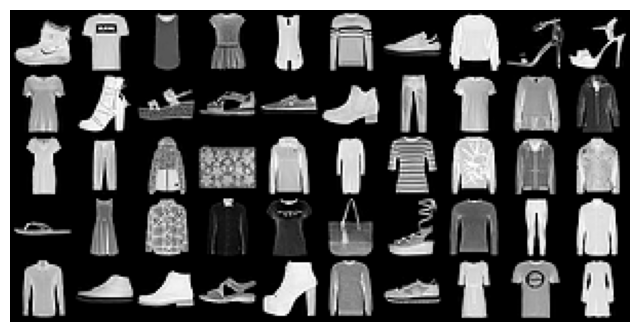

In [4]:
#plot categories mixed
plot_tiles(training_data.data, 10, 5)

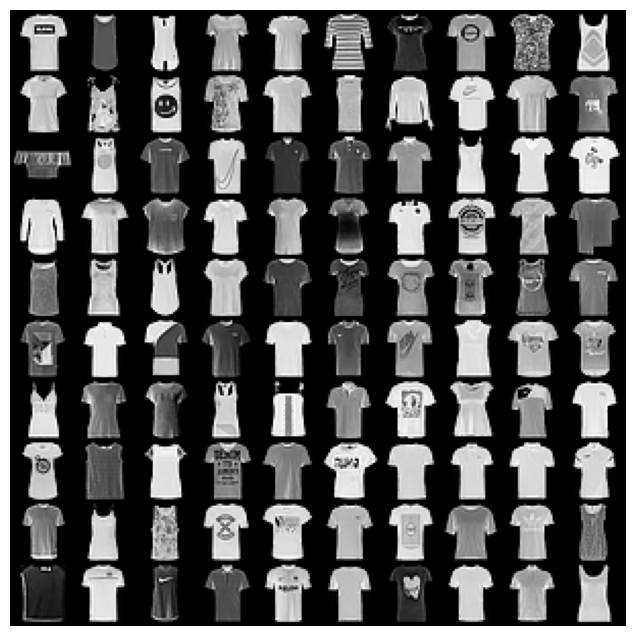

In [26]:
#plot only certain categorie
label = 0
plot_tiles(training_data.data[training_data.targets == label], 10,10)

#### Define the neural network

In [6]:
class SingleLayerPerceptron:
    """
    Single layer Perceptron class doing the forward and backward step
    """
    def __init__(self, num_input, num_output):
        """
        constructor

        Arguments:
        num_input -- number of input values
        num_output -- number of output values (categories)
        
        """
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_input, num_output),
            #we don't require softmax layer because it is included (for numerical reasons) in the cross entropy cost below           
        )                  
        
        self.cost_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        
    def propagate(self, X):
        """
        calculates the function estimation based on current parameters [W,B]
        """    
        self.Y_pred = self.model(X)
           
     
    def back_propagate(self, cost):
        """
        calculates the backpropagation results based on expected output y
        this function must be performed AFTER the corresponding propagte step
        """    
        self.model.zero_grad()
        
        cost.backward()
 

    def calc_cost(self, Y):
        """
        calculates the MSE loss function
        """
        cost = self.cost_fn(self.Y_pred, Y)
        
        return cost
    
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        with torch.no_grad():
            for param in self.model.parameters():
                param -= alpha * param.grad
            
     
        
    def calc_error(self, Y):
        """
        get error information
        """
        m = Y.shape[0]

        Y_pred_argmax = torch.argmax(self.Y_pred, dim=1)
        train_error = torch.sum(Y != Y_pred_argmax) / m

        return train_error

        
        
    def optimize(self, data, epochs, alpha, debug=0):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with data
        epochs -- number of epochs
        alpha -- learning rate
        debug -- False (default)/True; get info on each gradient descend step
        """
        
        # save results before 1st step
        for i0 in range(0, epochs):
            #do prediction
            self.propagate(data['X_train'])
            #determine the loss 
            cost = self.calc_cost(data['Y_train'])
            #determine the error
            self.back_propagate(cost)
            #do the correction step
            self.gradient_descend(alpha)
            #calculate the error
            error = self.calc_error(data['Y_train'])
            
            if debug and np.mod(i0, debug) == 0:
                print('step %r, cost %r, error %r' % (i0, cost.item(), error.item()))
                        
            

In [7]:
#normalize data: original data is overwritten
data_min, data_max = torch.min(training_data.data), torch.max(training_data.data)
print('original min-max values are: %r, %r and type %r' % (data_min.item(), data_max.item(), data_min.dtype))

normalize_tpye = 0

if normalize_tpye == 0:
    #min-max-rescaling
    training_data.data = (training_data.data.float() - data_min) / (data_max - data_min)    
    test_data.data = (test_data.data.float() - data_min) / (data_max - data_min)   
else:
    #min-max-normalization
    training_data.data = 2*(training_data.data.float() - data_min) / (data_max - data_min) - 1
    test_data.data = 2*(test_data.data.float() - data_min) / (data_max - data_min) - 1 

data_min, data_max = torch.min(training_data.data), torch.max(training_data.data)
print('now min-max values are: %r, %r and type %r' % (data_min.item(), data_max.item(), data_min.dtype))


original min-max values are: 0, 255 and type torch.uint8
now min-max values are: 0.0, 1.0 and type torch.float32


#### Define X and Y values and do optimization

In [8]:
#input is flattend to n x 784
data_X = training_data.data.flatten(1)
#labels are direclty supported by pytorch
data_Y = training_data.targets

data = {'X_train' : data_X, 'Y_train' : data_Y}

num_input = data_X.shape[1]
num_output = len(torch.unique(data_Y))
num_hidden = 100

slp = SingleLayerPerceptron(num_input,num_output)

slp.optimize(data, 500, 0.5, 50)


step 0, cost 2.3788068294525146, error 0.9392333626747131
step 50, cost 1.3318443298339844, error 0.2835666537284851
step 100, cost 1.0589462518692017, error 0.2631666660308838
step 150, cost 0.6950259208679199, error 0.19470000267028809
step 200, cost 0.9266583919525146, error 0.20241667330265045
step 250, cost 0.7953913807868958, error 0.21070000529289246
step 300, cost 0.7086988687515259, error 0.19528333842754364
step 350, cost 0.9046503901481628, error 0.20866666734218597
step 400, cost 0.6549509763717651, error 0.1899999976158142
step 450, cost 0.9423052668571472, error 0.20983333885669708


#### plot false classified images

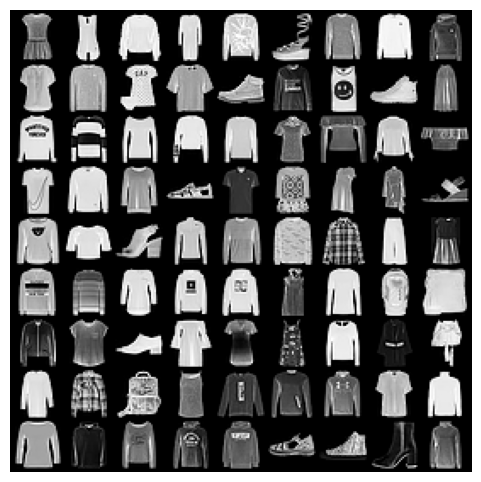

[0 1 4 4 4 8 6 6 4]
[0 6 6 0 7 6 6 7 4]
[4 4 6 4 6 0 6 4 8]
[6 6 6 7 6 6 0 4 9]
[6 8 9 4 6 6 4 4 0]
[4 6 6 4 4 0 6 4 6]
[6 6 7 6 6 0 6 6 6]
[4 4 4 6 6 4 4 0 4]
[6 6 6 4 4 7 5 5 6]


In [9]:
y_pred = torch.argmax(slp.model(data_X),1)

#select a number of false classifications (rows x cols) to plot
num_sel = 9

plot_tiles(training_data.data[y_pred != data_Y], num_sel, num_sel, figure_size = [6,6])

for i0 in range(0, num_sel):
    print(y_pred[y_pred != data_Y][i0*num_sel:(i0+1)*num_sel].numpy())

#### Evaluate error rate on test set

In [10]:
#input is flattend to n x 784
test_X = test_data.data.flatten(1)
#labels are direclty supported by pytorch
test_Y = test_data.targets

### START YOUR CODE ###

### END YOUR CODE ###


#### plot weights as images (rescale to [0,1] for output)

In [11]:
W = slp.model[0].weight.data.reshape(10, 28, 28)

### START YOUR CODE ###

### END YOUR CODE ###
